<a href="https://www.kaggle.com/code/haidermn16/augumented-roberta-ghosh-sarcasm-detection-dataset?scriptVersionId=225352265" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sarcasm Detection using RoBERTa and Emoji Embeddings

In this notebook, we will build a sarcasm detector that leverages both textual data processed by BERT and emoji embeddings processed through a custom emoji pathway. The model combines these modalities to predict whether a given text is sarcastic or not.

Training set class distribution:
label
0    27779
1    24800
Name: count, dtype: int64


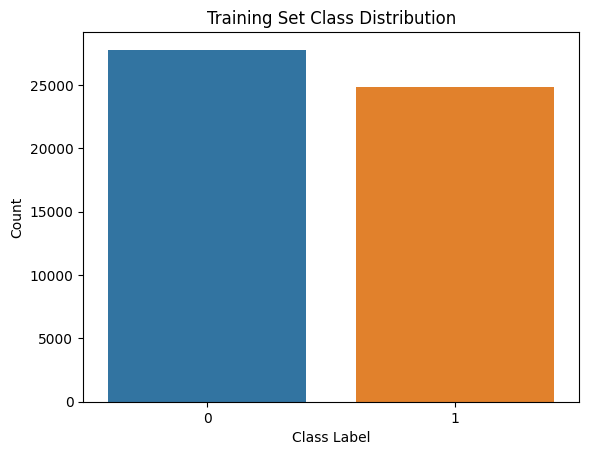


Test set class distribution:
label
0    1794
1     885
Name: count, dtype: int64


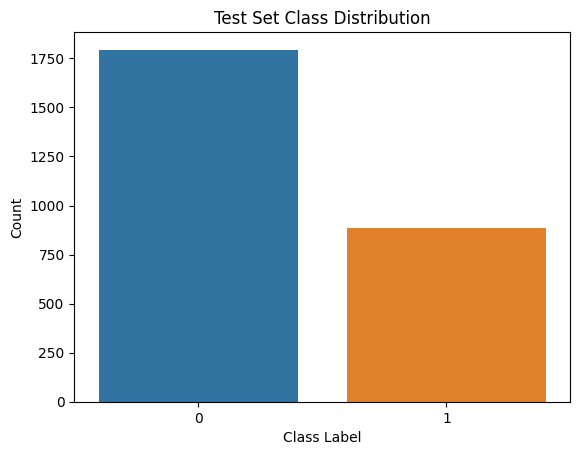

In [1]:
# DATASET analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
train_path = '/kaggle/input/ghosh-sarcasm-detection-dataset/clean_data.txt'
test_path = '/kaggle/input/ghosh-sarcasm-detection-dataset/test.txt'

# Function to load data
def load_data(file_path):
    texts = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # Skip empty lines
            try:
                text, label = line.rsplit(' ', 1)
                texts.append(text.strip())
                labels.append(int(label.strip()))
            except ValueError:
                continue  # Skip lines that don't have at least one space
    return pd.DataFrame({'text': texts, 'label': labels})

# Load datasets
train_df = load_data(train_path)
test_df = load_data(test_path)

# Combine datasets for analysis (if needed)
# full_df = pd.concat([train_df, test_df], ignore_index=True)

# Analyze class distribution in training set
train_counts = train_df['label'].value_counts().sort_index()
print("Training set class distribution:")
print(train_counts)

# Plot the class distribution
sns.countplot(x='label', data=train_df)
plt.title('Training Set Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

# Analyze class distribution in test set
test_counts = test_df['label'].value_counts().sort_index()
print("\nTest set class distribution:")
print(test_counts)

# Plot the class distribution
sns.countplot(x='label', data=test_df)
plt.title('Test Set Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

## 0. Augumentation 

In [2]:
# ---------------------------
# Ensure NLTK WordNet is ready (downloaded and unzipped)
# ---------------------------
import os
import zipfile
import nltk

# Set the NLTK data directory (Kaggle typically uses '/root/nltk_data')
nltk_data_dir = '/root/nltk_data'
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Add the directory to nltk data path if not already there
if nltk_data_dir not in nltk.data.path:
    nltk.data.path.append(nltk_data_dir)

# First, download wordnet (this will not re-download if it's up-to-date)
nltk.download('wordnet', download_dir=nltk_data_dir, quiet=True)
nltk.download('omw-1.4', download_dir=nltk_data_dir, quiet=True)

# Check if WordNet corpus is unzipped
wordnet_dir = os.path.join(nltk_data_dir, 'corpora', 'wordnet')
if not os.path.isdir(wordnet_dir):
    # Look for the zipped file
    wordnet_zip = os.path.join(nltk_data_dir, 'corpora', 'wordnet.zip')
    if os.path.exists(wordnet_zip):
        print("Unzipping wordnet.zip ...")
        with zipfile.ZipFile(wordnet_zip, 'r') as zip_ref:
            zip_ref.extractall(os.path.join(nltk_data_dir, 'corpora'))
        print("Unzipping complete.")
    else:
        print("WordNet data not found. Please check your NLTK installation.")

# ---------------------------
# Now define your augmentation functions (EDA)
# ---------------------------
import random
from nltk.corpus import wordnet

def get_synonyms(word):
    """Get a list of synonyms for a given word from WordNet."""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').lower()
            if synonym != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(words, n):
    """Replace n words in the sentence with one of their synonyms."""
    new_words = words.copy()
    random_word_list = list(set([word for word in words if get_synonyms(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for word in random_word_list:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if w == word else w for w in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def random_insertion(words, n):
    """Randomly insert n synonyms into the sentence."""
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    """Helper function to insert a random synonym into the sentence."""
    synonyms = []
    counter = 0
    while len(synonyms) < 1 and counter < 10:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
    if synonyms:
        random_synonym = random.choice(synonyms)
        random_idx = random.randint(0, len(new_words))
        new_words.insert(random_idx, random_synonym)

def random_swap(words, n):
    """Randomly swap two words in the sentence n times."""
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return new_words

def swap_word(words):
    """Helper function to swap two random words in the list."""
    new_words = words.copy()
    idx1 = random.randint(0, len(new_words)-1)
    idx2 = idx1
    counter = 0
    while idx2 == idx1 and counter < 3:
        idx2 = random.randint(0, len(new_words)-1)
        counter += 1
    new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

def random_deletion(words, p):
    """Randomly delete words from the sentence with probability p."""
    if len(words) == 1:
        return words  # Return if only one word.
    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:
            new_words.append(word)
    if not new_words:
        return [random.choice(words)]
    return new_words

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4):
    """
    Apply Easy Data Augmentation (EDA) on the input sentence.
    Returns a list of augmented sentences.
    """
    words = sentence.split()
    num_words = len(words)
    augmented_sentences = []
    n_sr = max(1, int(alpha_sr * num_words))
    n_ri = max(1, int(alpha_ri * num_words))
    n_rs = max(1, int(alpha_rs * num_words))
    
    # 1. Synonym Replacement
    a_words = synonym_replacement(words, n_sr)
    augmented_sentences.append(" ".join(a_words))
    
    # 2. Random Insertion
    a_words = random_insertion(words, n_ri)
    augmented_sentences.append(" ".join(a_words))
    
    # 3. Random Swap
    a_words = random_swap(words, n_rs)
    augmented_sentences.append(" ".join(a_words))
    
    # 4. Random Deletion
    a_words = random_deletion(words, p_rd)
    augmented_sentences.append(" ".join(a_words))
    
    while len(augmented_sentences) < num_aug:
        augmented_sentences.append(random.choice(augmented_sentences))
    
    return augmented_sentences[:num_aug]

# ---------------------------
# Functions to load and augment training data
# ---------------------------
def load_training_data(file_path):
    """
    Load training data from a file where each line is 'text label'.
    """
    texts = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                text, label = line.rsplit(' ', 1)
                texts.append(text.strip())
                labels.append(int(label.strip()))
            except Exception as e:
                print(f"Error processing line: {line}\n{e}")
                continue
    return texts, labels

def augment_training_data(input_path, output_path, num_aug=2):
    """
    Augment the training data and save to a new file.
    Each original sentence is retained along with 'num_aug' augmented variants.
    """
    texts, labels = load_training_data(input_path)
    augmented_texts = []
    augmented_labels = []
    
    for text, label in zip(texts, labels):
        # Add the original sentence
        augmented_texts.append(text)
        augmented_labels.append(label)
        # Generate augmented sentences
        aug_texts = eda(text, num_aug=num_aug)
        augmented_texts.extend(aug_texts)
        augmented_labels.extend([label] * len(aug_texts))
    
    with open(output_path, 'w', encoding='utf-8') as f:
        for text, label in zip(augmented_texts, augmented_labels):
            f.write(f"{text} {label}\n")
    print(f"Augmented training data saved to {output_path}")

# ---------------------------
# Run the augmentation
# ---------------------------
train_input_path = '/kaggle/input/ghosh-sarcasm-detection-dataset/clean_data.txt'
train_augmented_path = '/kaggle/working/train_aug.txt'

# For example, generating 2 augmented sentences per original sentence.
augment_training_data(train_input_path, train_augmented_path, num_aug=2)


Unzipping wordnet.zip ...
Unzipping complete.
Augmented training data saved to /kaggle/working/train_aug.txt


### 1. Import Necessary Libraries

In [3]:
import torch
import torch.nn as nn
from transformers import BertModel
from sklearn.metrics import f1_score, precision_score, recall_score
import os
import numpy as np
from typing import List
import gensim.models as gsm
from pathlib import Path
import argparse
import time
import matplotlib.pyplot as plt 
import pickle

from transformers import RobertaModel, RobertaTokenizer

### 2. Define helper functions

In [4]:
#utils_emoji.py

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from transformers import RobertaModel, RobertaTokenizer
import pandas as pd
import numpy as np

class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'raw_text': text
        }

def prepare_bert_data(train_path, val_path, test_path, tokenizer, batch_size=16):
    # Function to parse data files and create data loaders

    def load_data(file_path):
        texts, labels = [], []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue  # Skip empty lines
                try:
                    text, label = line.rsplit(' ', 1)
                    texts.append(text.strip())
                    labels.append(int(label.strip()))
                except ValueError:
                    continue  # Skip lines that don't have at least one space
        return texts, labels

    # Load training data
    train_texts, train_labels = load_data(train_path)

    # Load validation data
    val_texts, val_labels = load_data(val_path)

    # Load test data
    test_texts, test_labels = load_data(test_path)

    # Create datasets
    train_dataset = SarcasmDataset(train_texts, train_labels, tokenizer)
    val_dataset = SarcasmDataset(val_texts, val_labels, tokenizer)
    test_dataset = SarcasmDataset(test_texts, test_labels, tokenizer)

    
    # Define collate function
    def collate_fn(batch):
        return {
            'input_ids': torch.stack([item['input_ids'] for item in batch]),
            'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
            'labels': torch.stack([item['labels'] for item in batch]),
            'raw_text': [item['raw_text'] for item in batch]
        }
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader, tokenizer

# if __name__ == "__main__":
#     train_loader, val_loader, test_loader, tokenizer = prepare_bert_data(
#         'data/riloff/train.txt',
#         'data/riloff/test.txt',
#         batch_size=16
#     )
    
#     batch = next(iter(train_loader))
#     print("Input shape:", batch['input_ids'].shape)
#     print("Attention mask shape:", batch['attention_mask'].shape)
#     print("Labels shape:", batch['labels'].shape)
#     print("Raw text length:", len(batch['raw_text']))

In [5]:
#split.py


import random
import shutil

# File paths
input_path = '/kaggle/working/train_aug.txt'  # Input data to split into train and val       
test_input_path = '/kaggle/input/ghosh-sarcasm-detection-dataset/test.txt'   # Test data is already defined
train_output_path = '/kaggle/working/train.txt'   # Output path for training data
val_output_path = '/kaggle/working/val.txt'       # Output path for validation data
test_output_path = '/kaggle/working/test.txt'     # Output path for testing data

# Load data from clean_data.txt
data = []
with open(input_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if not line:
            continue  # Skip empty lines
        # Split line into text and label
        # Since the label is at the end, we can split from the right
        try:
            text, label = line.rsplit(' ', 1)
            data.append((text.strip(), label.strip()))
        except ValueError:
            continue  # Skip lines that don't have at least one space

# Shuffle data
random.shuffle(data)

# Split data into train and validation sets
split_ratio = 0.9  # Use 90% of data for training, 10% for validation
split_index = int(split_ratio * len(data))
train_data = data[:split_index]
val_data = data[split_index:]

# Save training data to file
with open(train_output_path, 'w', encoding='utf-8') as train_file:
    for text, label in train_data:
        train_file.write(f"{text} {label}\n")  # Write as 'text label'

# Save validation data to file
with open(val_output_path, 'w', encoding='utf-8') as val_file:
    for text, label in val_data:
        val_file.write(f"{text} {label}\n")

# Copy test data to /kaggle/working/test.txt (if needed)
test_source_path = '/kaggle/input/ghosh-sarcasm-detection-dataset/test.txt'
# If the test data is not already in the correct format, process it similarly
with open(test_source_path, 'r', encoding='utf-8') as test_input_file, \
     open(test_output_path, 'w', encoding='utf-8') as test_output_file:
    for line in test_input_file:
        line = line.strip()
        if not line:
            continue  # Skip empty lines
        # Assuming test data is in the same format as clean_data.txt
        try:
            text, label = line.rsplit(' ', 1)
            test_output_file.write(f"{text} {label}\n")
        except ValueError:
            continue  # Skip lines that don't have at least one space

print("Data has been split and saved to 'train.txt', 'val.txt', and 'test.txt' in the /kaggle/working directory.")

Data has been split and saved to 'train.txt', 'val.txt', and 'test.txt' in the /kaggle/working directory.


In [6]:
# Check training data
print("First few lines of train.txt:")
with open('/kaggle/working/train.txt', 'r', encoding='utf-8') as f:
    for _ in range(5):
        print(next(f).strip())

# Check validation data
print("\nFirst few lines of val.txt:")
with open('/kaggle/working/val.txt', 'r', encoding='utf-8') as f:
    for _ in range(5):
        print(next(f).strip())

# Check test data
print("\nFirst few lines of test.txt:")
with open('/kaggle/working/test.txt', 'r', encoding='utf-8') as f:
    for _ in range(5):
        print(next(f).strip())

First few lines of train.txt:
happy birthday @user . ace miss you hope , you enjoy your day ! 0
aught like a man in a nice fitted suit 😩 1
@user so wins against UNK and psu can validate conference wide strength , but can't validate osu team strength ? hmmm 0
ben UNK | jack UNK vai UNK a UNK movie theatre not íc i as 1
my pop exploded everywhere wow im having a great 24-hour interval ! :) 1

First few lines of val.txt:
i'm going to cry because i'm operate going to miss @user so much when he's gone ... 😭 😂 1
alright i'm assuming that one love is probably available in canada now too axerophthol antiophthalmic factor . someone get me a towel ? 0
i've never failed a class more UNK than ap physics 0
wow .. how freaking amazing was that . 0
i guess i'm a professional wrestler now ... i immobilise a guy down in theater now . yay blocking ? 😂 😂 😳 um mm UNK of the UNK shakespeare awkward 1

First few lines of test.txt:
love you more , girlfriend 😍 hehehe 😘 0
@user rest in peace & love to you and

### 3. Define the EmojiEncoder Class
The EmojiEncoder extracts emojis from text and converts them into embeddings using a pre-trained emoji2vec model.

In [7]:
class EmojiEncoder(nn.Module):
    """Encodes emoji sequences into fixed-dimensional embeddings."""
    
    def __init__(self, emoji_dim: int = 300, model_path: str = '/kaggle/input/code_modules/tensorflow2/default/1/emoji2vec.bin'):
        """
        Args:
            emoji_dim: Output dimension of emoji embeddings
            model_path: Path to pre-trained emoji2vec binary file
        """
        super().__init__()
        
        if not Path(model_path).exists():
            raise FileNotFoundError(f"emoji2vec model not found at {model_path}")
            
        self.emoji2vec = gsm.KeyedVectors.load_word2vec_format(model_path, binary=True)
        self.projection = nn.Linear(self.emoji2vec.vector_size, emoji_dim)
        
    def forward(self, texts: List[str]) -> torch.Tensor:
        """
        Convert text sequences containing emojis to fixed-length embeddings.
        
        Args:
            texts: List of strings potentially containing emojis
            
        Returns:
            Tensor of shape (batch_size, seq_len, emoji_dim) containing emoji embeddings
        """
        batch_size = len(texts)
        device = next(self.projection.parameters()).device
        
        # Pre-allocate output tensor - adding sequence length dimension
        emoji_embeddings = torch.zeros(batch_size, 128, self.emoji2vec.vector_size)
        
        for i, text in enumerate(texts):
            # Extract emojis present in vocabulary
            emojis = [c for c in text if c in self.emoji2vec.key_to_index]
            
            if emojis:
                # Get embeddings for all emojis in text
                emoji_vecs = [self.emoji2vec[emoji] for emoji in emojis]
                # Stack emoji vectors along sequence dimension
                emoji_seq = torch.tensor(np.stack(emoji_vecs))
                # Pad or truncate to fixed sequence length
                if len(emoji_seq) > 128:
                    emoji_embeddings[i] = emoji_seq[:128]
                else:
                    emoji_embeddings[i, :len(emoji_seq)] = emoji_seq
                
        # Move to same device as model and project each embedding in the sequence
        emoji_embeddings = emoji_embeddings.to(device)
        emoji_embeddings = self.projection(emoji_embeddings)  # Shape: [batch_size, seq_len, emoji_dim]
        return emoji_embeddings

### 4.Define the Attention Mechanism
The Attention class implements an attention mechanism to focus on important parts of the sequence.

In [8]:
class Attention(nn.Module):
    def __init__(self, lstm_hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(lstm_hidden_size * 2, 1)

    def forward(self, lstm_out):
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        return context_vector

### 5. Define the SarcasmDetector Model
The SarcasmDetector combines BERT embeddings and emoji embeddings, processes them through separate pathways, and then fuses the features for classification.

In [9]:
class SarcasmDetector(nn.Module):
    def __init__(self, dropout_rate=0.5, freeze_bert=False):
        super(SarcasmDetector, self).__init__()
        
        # Replace BERT with RoBERTa
        self.bert = RobertaModel.from_pretrained('roberta-base')
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.bert_dim = self.bert.config.hidden_size  # Typically 768 for roberta-base
        
        # Add layer normalization
        self.bert_norm = nn.LayerNorm(self.bert_dim)
        self.emoji_norm = nn.LayerNorm(300)  # for emoji embeddings
        
        # Emoji components
        self.emoji_encoder = EmojiEncoder()
        
        # Channels and sizes
        self.cnn_out_channels = 256
        self.lstm_hidden_size = 256  # doubled
        self.dense_hidden_size = 256  # doubled
        
        # BERT pathway layers
        self.bert_conv = nn.Conv1d(
            in_channels=self.bert_dim,
            out_channels=self.cnn_out_channels,
            kernel_size=3,
            padding=1
        )
        
        self.bert_lstm = nn.LSTM(
            input_size=self.cnn_out_channels,
            hidden_size=self.lstm_hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate
        )
        
        self.bert_attention = Attention(self.lstm_hidden_size)
        
        # Emoji pathway layers
        self.emoji_conv = nn.Conv1d(
            in_channels=300,  # Original emoji dimension
            out_channels=self.cnn_out_channels,
            kernel_size=3,
            padding=1
        )
        
        self.emoji_lstm = nn.LSTM(
            input_size=self.cnn_out_channels,
            hidden_size=self.lstm_hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate
        )
        
        self.emoji_attention = Attention(self.lstm_hidden_size)
        
        # Fusion and classification layers
        combined_features_size = (self.lstm_hidden_size * 4)  # 2 * (lstm_hidden_size * 2)
        self.fusion = nn.Linear(combined_features_size, self.dense_hidden_size)
        
        self.dense1 = nn.Linear(self.dense_hidden_size, self.dense_hidden_size)
        self.dense2 = nn.Linear(self.dense_hidden_size, 2)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # Add batch normalization
        self.bert_bn = nn.BatchNorm1d(self.cnn_out_channels)
        self.emoji_bn = nn.BatchNorm1d(self.cnn_out_channels)
        
        # Add residual connections
        self.bert_residual = nn.Linear(self.bert_dim, self.lstm_hidden_size * 2)  # Match LSTM bidirectional output
        self.emoji_residual = nn.Linear(300, self.lstm_hidden_size * 2)  # Match LSTM bidirectional output

    def process_bert_features(self, embeddings):
        cnn_in = embeddings.permute(0, 2, 1)
        cnn_out = self.relu(self.bert_conv(cnn_in))
        lstm_in = cnn_out.permute(0, 2, 1)
        
        lstm_out, _ = self.bert_lstm(lstm_in)
        features = self.bert_attention(lstm_out)
        return features

    def process_emoji_features(self, embeddings):
        cnn_in = embeddings.permute(0, 2, 1)
        cnn_out = self.relu(self.emoji_conv(cnn_in))
        lstm_in = cnn_out.permute(0, 2, 1)
        
        lstm_out, _ = self.emoji_lstm(lstm_in)
        features = self.emoji_attention(lstm_out)
        return features

    def forward(self, input_ids, attention_mask, raw_texts):
        # Process BERT with residual connection
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = self.bert_norm(bert_output.last_hidden_state)
        bert_residual = self.bert_residual(bert_embeddings.mean(dim=1))  # [batch, lstm_hidden_size * 2]
        
        # Process emoji with residual connection
        emoji_embeddings = self.emoji_encoder(raw_texts)
        emoji_embeddings = self.emoji_norm(emoji_embeddings)
        emoji_residual = self.emoji_residual(emoji_embeddings.mean(dim=1))  # [batch, lstm_hidden_size * 2]
        
        # Main pathways with proper dimensions
        text_features = self.process_bert_features(bert_embeddings)  # [batch, lstm_hidden_size * 2]
        emoji_features = self.process_emoji_features(emoji_embeddings)  # [batch, lstm_hidden_size * 2]
        
        # Now dimensions match for residual connections
        text_features = text_features + bert_residual  # Both are [batch, lstm_hidden_size * 2]
        emoji_features = emoji_features + emoji_residual  # Both are [batch, lstm_hidden_size * 2]
        
        # Combine features
        combined_features = torch.cat([text_features, emoji_features], dim=1)
        
        # Continue through dense layers
        x = self.fusion(combined_features)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.dense2(x)
        predictions = self.softmax(logits)
        
        return predictions

### 7. Define Training and Evaluation Functions
The train_epoch function handles training for one epoch, and the evaluate function evaluates the model on the validation or test set.

In [10]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    total_steps = len(train_loader)
    
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        raw_texts = batch['raw_text']
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, raw_texts)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        total_loss += loss.item()
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f'  Step [{batch_idx + 1}/{total_steps}], Loss: {loss.item():.4f}')
    
    epoch_time = time.time() - start_time
    return total_loss / len(train_loader), epoch_time
def evaluate(model, test_loader, criterion, device, return_predictions=False):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            raw_texts = batch['raw_text']  # If needed

            outputs = model(input_ids, attention_mask, raw_texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

            if return_predictions:
                batch_preds = preds.cpu().numpy()
                batch_labels = labels.cpu().numpy()
                all_preds.extend(batch_preds)
                all_labels.extend(batch_labels)

            # Remove or comment out the batch predictions print statements
            # if batch_idx < 3:
            #     print(f"\nBatch {batch_idx}:")
            #     for i in range(min(5, len(batch_preds))):
            #         print(f"Pred: {batch_preds[i]}, True: {batch_labels[i]}")

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / len(test_loader.dataset)

    if return_predictions:
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        return avg_loss, accuracy, all_preds, all_labels
    else:
        return avg_loss, accuracy

### 8.Load Dataset and Preprocess Data
Prepare the data loaders for training and testing.

In [11]:
'''# Parse arguments (if running as a script, you can modify or remove argparse when using in a notebook)
parser = argparse.ArgumentParser(description='Train and evaluate Sarcasm Detector')
parser.add_argument('--dataset', type=str, help='Name of the dataset', default='Mishra')

args, unknown = parser.parse_known_args()
train_path = f'data/{args.dataset}/train.txt'
test_path = f'data/{args.dataset}/test.txt' '''

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Paths to your data files
train_path = '/kaggle/working/train.txt'
val_path = '/kaggle/working/val.txt'
test_path = '/kaggle/working/test.txt'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

from transformers import RobertaTokenizer

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Prepare data loaders
train_loader, val_loader, test_loader, tokenizer = prepare_bert_data(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    tokenizer=tokenizer,        # Pass the RoBERTa tokenizer
    batch_size=32
)

Using device: cuda
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

### 9. Initialize the Model, Optimizer, and Criterion
Set up the model, define the optimizer with different learning rates for different parts of the model, and specify the loss function.

In [12]:
model = SarcasmDetector(dropout_rate=0.5, freeze_bert=False).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

# Separate RoBERTa and task-specific parameters for different learning rates
optimizer = torch.optim.AdamW([
    {'params': model.bert.parameters(), 'lr': 2e-5},
    {'params': model.emoji_encoder.parameters(), 'lr': 1e-4},
    {'params': [p for n, p in model.named_parameters() 
                if not n.startswith('bert.') and not n.startswith('emoji_encoder.')], 
     'lr': 1e-3}
])

# Define the loss function

# Focal Loss instead of CrossEntropy
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
            
    def forward(self, input, target):
        ce_loss = nn.functional.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss
            
criterion = FocalLoss(gamma=2)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=25,  # number of epochs
    eta_min=1e-6
)

# Gradient clipping
max_grad_norm = 1.0

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of parameters: 131696664
Trainable parameters: 131696664


### 10. Train the Model
Train the model over multiple epochs, implement early stopping, and save the best model.

In [13]:
# Initialize metric storage
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epochs_list = []  # Renamed to avoid conflict with built-in function 'epochs'

# Initialize total training time
total_train_time = 0  # Initialize to zero before the training loop

# Define the maximum training time in seconds (8 hours)
max_training_time = 8 * 60 * 60  # 8 hours in seconds

# Initialize early stopping variables
best_loss = float('inf')
patience = 1
patience_counter = 0
model_path = '/kaggle/working/sarcasm_detector_model.pth'

# Load the model if it exists
if os.path.exists(model_path):
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training model...")

for epoch in range(25):
    print(f'\nEpoch {epoch+1}/25')
    train_loss, epoch_time = train_epoch(model, train_loader, optimizer, criterion, device)
    total_train_time += epoch_time

    # Evaluate on training set
    print("\nEvaluating on training set:")
    train_loss_e, train_accuracy = evaluate(model, train_loader, criterion, device)

    # Evaluate on validation set
    print("\nEvaluating on validation set:")
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    # Record metrics
    train_losses.append(train_loss_e)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    epochs_list.append(epoch + 1)

    # Epoch summary
    print(f'\nEpoch Summary:')
    print(f'Train Loss: {train_loss_e:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    print(f'Epoch Time: {epoch_time:.2f}s')
    print(f'Total Training Time: {total_train_time/60:.2f} minutes')

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Early Stopping based on validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Check for maximum training time
    if total_train_time >= max_training_time:
        print(f"Maximum training time of {max_training_time/3600} hours reached. Stopping training.")
        break

print("Training complete!")

# Save training metrics to disk
metrics = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'epochs': epochs_list,
}

metrics_path = '/kaggle/working/training_metrics.pkl'
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics, f)
print(f"Training metrics saved to {metrics_path}")

Training model...

Epoch 1/25
  Step [10/4437], Loss: 0.1710
  Step [20/4437], Loss: 0.1777
  Step [30/4437], Loss: 0.1366
  Step [40/4437], Loss: 0.1441
  Step [50/4437], Loss: 0.1824
  Step [60/4437], Loss: 0.1334
  Step [70/4437], Loss: 0.1806
  Step [80/4437], Loss: 0.1516
  Step [90/4437], Loss: 0.1609
  Step [100/4437], Loss: 0.1427
  Step [110/4437], Loss: 0.1408
  Step [120/4437], Loss: 0.1455
  Step [130/4437], Loss: 0.1852
  Step [140/4437], Loss: 0.1678
  Step [150/4437], Loss: 0.2085
  Step [160/4437], Loss: 0.1241
  Step [170/4437], Loss: 0.1423
  Step [180/4437], Loss: 0.1555
  Step [190/4437], Loss: 0.0988
  Step [200/4437], Loss: 0.1578
  Step [210/4437], Loss: 0.1746
  Step [220/4437], Loss: 0.1579
  Step [230/4437], Loss: 0.1962
  Step [240/4437], Loss: 0.1297
  Step [250/4437], Loss: 0.1116
  Step [260/4437], Loss: 0.1581
  Step [270/4437], Loss: 0.1138
  Step [280/4437], Loss: 0.1561
  Step [290/4437], Loss: 0.1191
  Step [300/4437], Loss: 0.1631
  Step [310/4437], 

### 11. Evaluate the Model
Load the best saved model and evaluate its performance on the test set.

<ipython-input-14-7a81ad1a3a7b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Final Test Loss: 0.0677, Test Accuracy: 0.9246


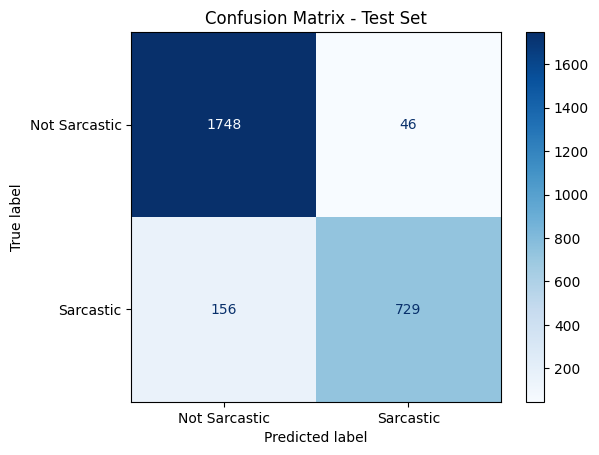

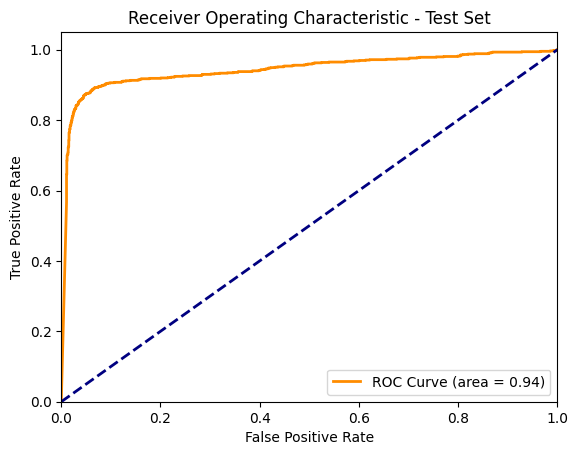

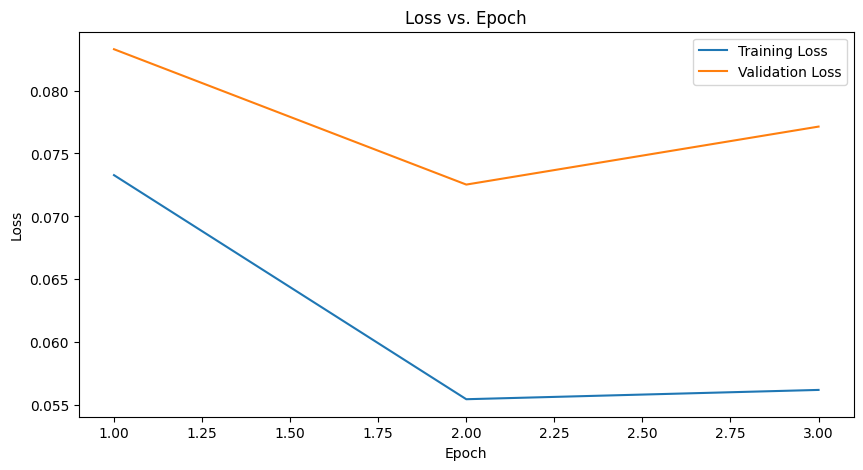

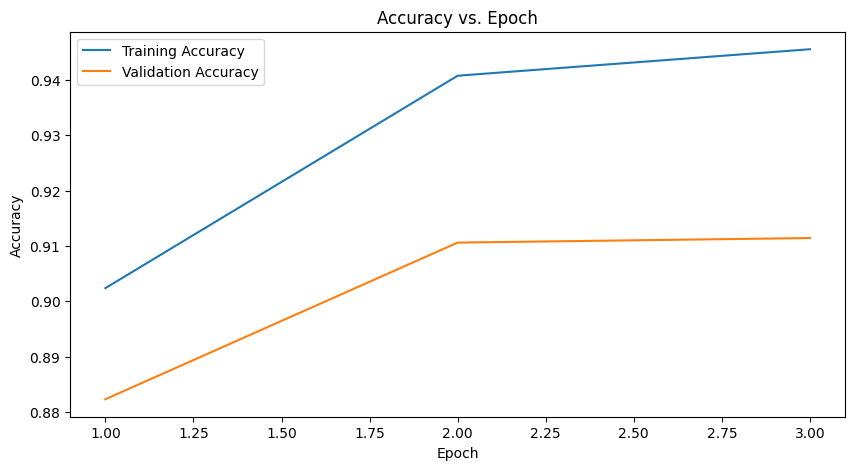

Final Test Loss: 0.0677, Test Accuracy: 0.9246, F1-score: 0.8783


In [14]:
# Load the best model
model.load_state_dict(torch.load(model_path))
model.to(device)

# Evaluate on the test set and get predictions
test_loss, test_accuracy, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device, return_predictions=True
)
print(f'Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()










# Plot ROC Curve (Optional)
from sklearn.metrics import roc_curve, auc

# Compute prediction probabilities
def get_probs(model, test_loader, device):
    model.eval()
    probs = []
    labels_list = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            raw_texts = batch['raw_text']

            outputs = model(input_ids, attention_mask, raw_texts)
            probabilities = outputs[:, 1].cpu().numpy()  # Assuming class 1 is 'Sarcastic'

            probs.extend(probabilities)
            labels_list.extend(labels.cpu().numpy())

    return np.array(probs), np.array(labels_list)

# Get probabilities and labels
probs, labels = get_probs(model, test_loader, device)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set')
plt.legend(loc='lower right')
plt.show()
# ... (previous ROC curve code)







# Plot Training Metrics
# Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()



# Compute F1-score
from sklearn.metrics import f1_score

f1 = f1_score(test_labels, test_preds)  # Default is binary classification

print(f'Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1-score: {f1:.4f}')


### 12. Conclusion
In this notebook, we built a sarcasm detection model that effectively combines textual data processed by BERT and emoji embeddings. We implemented attention mechanisms, residual connections, and used focal loss to handle class imbalance. The model was trained using a cosine annealing scheduler and gradient clipping to improve performance.

